# AI - Vaacum agent

Modified with three rooms (i.e. (0,0), (1,0), (2,0)) instead of two.

Perception is restricted to the room the agent is in. 

No preference about directions toward other rooms is possibile, as these latter status is unknown. 

Created: (R. Basili, Nov. 2020)  
Last Edit: (C.D. Hromei, Oct. 2024)
           (G.De Luca, Oct. 2025)

## The (not so) abstract vision of an Agent

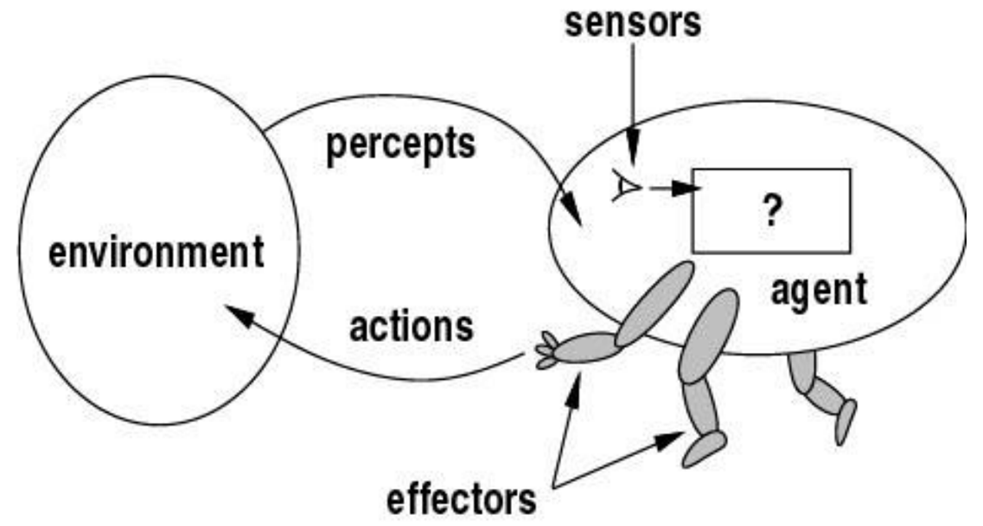

## Simple vacuum agent (2 rooms only)

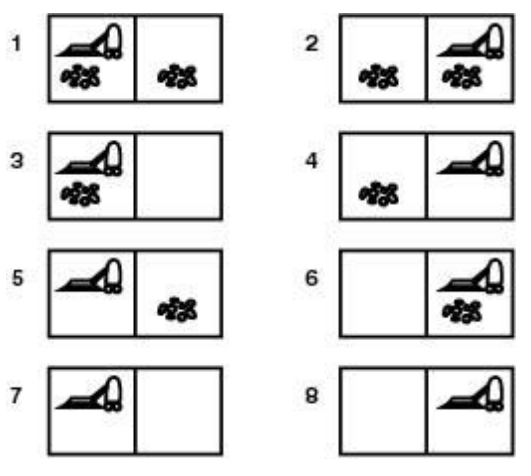

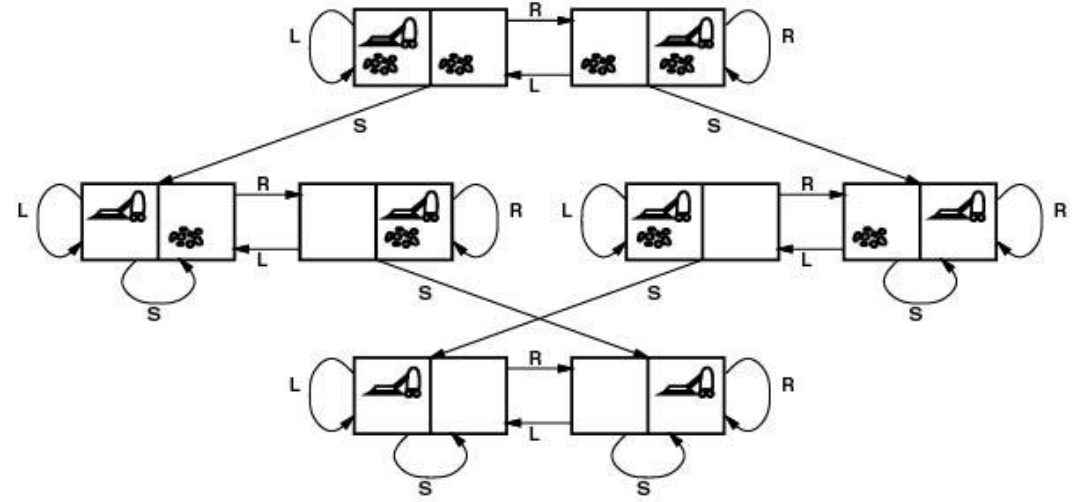

In [1]:
from tkinter import *
import random
from agents import *

from PIL import ImageTk, Image
import os 


my_image = "roomba2.png"

# Location class definition
class Location:
    def __init__(self, number: int):
        self.number = number
        self.coordinates = (number, 0)
        self.states = ['Dirty', 'Clean']
        self.status = self.states[random.randint(0, 1)]

    def switch_status(self):
        if self.status == 'Dirty':
            self.status = 'Clean'
        else:
            self.status = 'Dirty'


class Gui(Environment):
    """This GUI environment has multiple locations. Each can be Dirty
    or Clean. The agent perceives its location and the location's status."""

    def __init__(self, root, height=400, width=520, location_number=5, image=None):
        super().__init__()

        self.locations = [Location(i) for i in range(location_number)]
        self.location_number = location_number
        self.status = {loc.coordinates: loc.status for loc in self.locations}
        self.image = [ImageTk.PhotoImage(Image.open(image).resize((40, 40))) if image else None]
        self.root = root
        self.height = height
        self.width = width + (30 * location_number) 
        self.canvas = None
        self.buttons = []
        self.score_label = None
        self.create_canvas()
        self.create_buttons()
        self.create_score_display()

    def thing_classes(self):
        """The list of things which can be used in the environment."""
        return [Wall, Dirt, ReflexVacuumAgent, RandomVacuumAgent,
                TableDrivenVacuumAgent, ModelBasedVacuumAgent]

    def percept(self, agent):
        """Returns the agent's location, and the location status (Dirty/Clean)."""
        current_location = self.get_location_by_coordinates(agent.location)
        status = current_location.status if current_location else 'Clean'
        print('Perceived Location=', agent.location, ' - Perceived StatusAtLoc=', status)
        return (agent.location, status)
    
    def get_location_by_coordinates(self, coordinates):
        """Helper method to get a Location object by its coordinates."""
        for loc in self.locations:
            if loc.coordinates == coordinates:
                return loc
        return None
    
    def get_location_by_number(self, number):
        """Helper method to get a Location object by its number."""
        for loc in self.locations:
            if loc.number == number:
                return loc
        return None

    def execute_action(self, agent, action):
        """Change the location status (Dirty/Clean); track performance.
        Score 10 for each dirt cleaned; -1 for each move."""
        print('Executing action: ', action)
        current_loc_num = agent.location[0]  # Get location number from coordinates
        
        if action == 'Right':
            if current_loc_num < self.location_number - 1:
                agent.location = (current_loc_num + 1, 0)
            agent.performance -= 1
        elif action == 'Left':
            if current_loc_num > 0:
                agent.location = (current_loc_num - 1, 0)
            agent.performance -= 1
        elif action == 'Suck':
            current_location = self.get_location_by_coordinates(agent.location)
            if current_location and current_location.status == 'Dirty':
                button_index = current_location.number
                self.buttons[button_index].config(bg='white')
                agent.performance += 10
                current_location.status = 'Clean'
                self.status[current_location.coordinates] = 'Clean'

    def default_location(self, _):
        """Agents start in a random location."""
        random_loc = random.choice(self.locations)
        return random_loc.coordinates

    def create_canvas(self):
        """Creates Canvas element in the GUI."""
        self.canvas = Canvas(
            self.root,
            width=self.width,
            height=self.height,
            background='powder blue')
        self.canvas.pack(side='bottom')

    def create_score_display(self):
        """Creates a label to display the agent's score."""
        self.score_label = Label(self.root, text="Score: 0", 
                                font="Helvetica 16 bold", 
                                bg='powder blue',
                                fg='navy')
        self.canvas.create_window(self.width // 2, 30, window=self.score_label)

    def create_buttons(self):
        """Creates the buttons required in the GUI."""
        button_spacing = self.width / (self.location_number + 1)
        
        for i, location in enumerate(self.locations):
            x_pos = button_spacing * (i + 1)
            
            bg_color = 'saddle brown' if location.status == 'Dirty' else 'white'
            
            button = Label(self.root, height=4, width=12, 
                          bg=bg_color, relief=RAISED, borderwidth=2,
                          )
            button.bind("<Button-1>", lambda e, idx=i: self.dirt_switch(idx))
            self.buttons.append(button)
            self.canvas.create_window(x_pos, 200, anchor=N, window=button)

    def dirt_switch(self, button_index):
        """Gives user the option to put dirt in any tile."""
        button = self.buttons[button_index]
        location = self.locations[button_index]
        
        location.switch_status()
        
        if location.status == 'Clean':
            button.config(bg='white')
            print(f"Button {button_index} (Location {location.number}): Dirty -> Clean")
        else:
            button.config(bg='saddle brown')
            print(f"Button {button_index} (Location {location.number}): Clean -> Dirty")
        
        self.status[location.coordinates] = location.status
        
        print(f"Current status: {self.status}")
        button.update()  

    def read_env(self):
        """Reads the current state of the GUI."""
        for i, (btn, location) in enumerate(zip(self.buttons, self.locations)):
            bg = btn.cget('bg')
            location.status = 'Clean' if bg in ['white', 'SystemButtonFace'] else 'Dirty'
            self.status[location.coordinates] = location.status

    def update_env(self, agent):
        """Updates the GUI according to the agent's action."""
        before_step = agent.location
        self.step()  
        
        for loc in self.locations:
            self.status[loc.coordinates] = loc.status
            
        print('Current Environment Status: ', self.status)
        print('Current Agent Location: ', agent.location)
        print('Current Agent Performance: ', agent.performance)
        
        self.score_label.config(text=f"Score: {agent.performance}")
        
        move_agent(self, agent, before_step)


def ReflexVacuumAgent():
    """A reflex agent for the multi-location vacuum environment."""
    
    def program(percept):
        location, status = percept
        print('Perceived Status: ', percept)
        if status == 'Dirty':
            print('Selected Action: ', 'Suck')
            return 'Suck'
        else:
            Mode = random.choice(['Right', 'Left'])
            print('Randomly Selected Action: ', Mode)
            return Mode
    
    return Agent(program)


def create_agent(env, agent, image):
    """Creates the agent in the GUI and is kept independent of the environment."""
    env.add_thing(agent)
    
    location_num = agent.location[0]
    button_spacing = env.width / (env.location_number + 1)
    x_pos = button_spacing * (location_num + 1)
    y_pos = 150 
    
    env.text = env.canvas.create_text(x_pos, 120, 
                                      font="Helvetica 12 bold", 
                                      text="Agent",
                                      fill = 'navy')
    
    if image:
        env.agent_logo = env.canvas.create_image(x_pos, y_pos + 10, image=image)
    else: 
        env.agent_logo = env.canvas.create_oval(x_pos - 10, y_pos, x_pos + 10, y_pos + 20, 
                                           fill='red')


def move_agent(env, agent, before_step):
    """Moves the agent in the GUI when 'next' button is pressed."""
    if agent.location == before_step:
        return
    
    old_num = before_step[0]
    new_num = agent.location[0]
    button_spacing = env.width / (env.location_number + 1)
    dx = (new_num - old_num) * button_spacing    
    env.canvas.move(env.text, dx, 0)
    env.canvas.move(env.agent_logo, dx, 0)


# TODO: Add more agents to the environment.
# TODO: Expand the environment to XYEnvironment.

def main():
    """The main function of the program."""
    root = Tk()
    root.title("Vacuum Environment")
    
    location_count = 5 
    width = 520
    adjusted_width = width + (30 * location_count)
    
    root.geometry(f"{adjusted_width}x450")
    root.resizable(0, 0)
    
    frame = Frame(root, bg='powder blue')
    next_button = Button(frame, text='Next', height=2, width=8, padx=2, pady=2, 
                        font="Helvetica 12 bold")
    next_button.pack(side='left')
    frame.pack(side='bottom', pady=12)

    env = Gui(root, location_number=location_count)
    agent = ReflexVacuumAgent()
    imageref = [ImageTk.PhotoImage(Image.open(my_image).resize((40, 40))) if my_image else None]
    create_agent(env, agent, imageref)
    
    next_button.config(command=lambda: env.update_env(agent))
    
    root.mainloop()


if __name__ == "__main__":
    main()

2025-10-17 11:05:32.024 python[98928:15513777] +[IMKClient subclass]: chose IMKClient_Modern
2025-10-17 11:05:32.024 python[98928:15513777] +[IMKInputSession subclass]: chose IMKInputSession_Modern


Perceived Location= (3, 0)  - Perceived StatusAtLoc= Clean
Perceived Status:  ((3, 0), 'Clean')
Randomly Selected Action:  Left
Executing action:  Left
Current Environment Status:  {(0, 0): 'Dirty', (1, 0): 'Dirty', (2, 0): 'Clean', (3, 0): 'Clean', (4, 0): 'Dirty'}
Current Agent Location:  (2, 0)
Current Agent Performance:  -1
Perceived Location= (2, 0)  - Perceived StatusAtLoc= Clean
Perceived Status:  ((2, 0), 'Clean')
Randomly Selected Action:  Left
Executing action:  Left
Current Environment Status:  {(0, 0): 'Dirty', (1, 0): 'Dirty', (2, 0): 'Clean', (3, 0): 'Clean', (4, 0): 'Dirty'}
Current Agent Location:  (1, 0)
Current Agent Performance:  -2
Perceived Location= (1, 0)  - Perceived StatusAtLoc= Dirty
Perceived Status:  ((1, 0), 'Dirty')
Selected Action:  Suck
Executing action:  Suck
Current Environment Status:  {(0, 0): 'Dirty', (1, 0): 'Clean', (2, 0): 'Clean', (3, 0): 'Clean', (4, 0): 'Dirty'}
Current Agent Location:  (1, 0)
Current Agent Performance:  8
Perceived Location= 

: 